In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers, models, optimizers, regularizers
import pandas as pd
import os
from zipfile import ZipFile

In [ ]:
# Mount drive
# drive.mount('/content/drive/MyDrive/Computer Vision Project')

# Copy the zip file to Colab's local storage
!cp "/content/drive/MyDrive/Computer Vision Project/Kaggle_Data/stanford_cars_train.zip" /content/
!cp "/content/drive/MyDrive/Computer Vision Project/Kaggle_Data/stanford_cars_test.zip" /content/

# Create a destination directory and extract the dataset
!mkdir -p /content/dataset/train
!mkdir -p /content/dataset/test
!unzip "/content/drive/MyDrive/Computer Vision Project/Kaggle_Data/stanford_cars_train.zip" -d /content/dataset/train
!unzip "/content/drive/MyDrive/Computer Vision Project/Kaggle_Data/stanford_cars_test.zip" -d /content/dataset/test

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/test/cars_test/01440.jpg  
  inflating: /content/dataset/test/cars_test/07582.jpg  
  inflating: /content/dataset/test/cars_test/05395.jpg  
  inflating: /content/dataset/test/cars_test/06313.jpg  
  inflating: /content/dataset/test/cars_test/05800.jpg  
  inflating: /content/dataset/test/cars_test/01871.jpg  
  inflating: /content/dataset/test/cars_test/06878.jpg  
  inflating: /content/dataset/test/cars_test/02439.jpg  
  inflating: /content/dataset/test/cars_test/03727.jpg  
  inflating: /content/dataset/test/cars_test/07541.jpg  
  inflating: /content/dataset/test/cars_test/00548.jpg  
  inflating: /content/dataset/test/cars_test/07742.jpg  
  inflating: /content/dataset/test/cars_test/05356.jpg  
  inflating: /content/dataset/test/cars_test/03041.jpg  
  inflating: /content/dataset/test/cars_test/01642.jpg  
  inflating: /content/dataset/test/cars_test/01656.jpg  
  inflating: /content/dataset/test/ca

In [ ]:
# Dataset paths
train_data_dir = '/content/dataset/train/cars_train'
test_data_dir = '/content/dataset/test/cars_test'

In [ ]:
# Load labels
train_labels = pd.read_csv('/content/drive/MyDrive/Computer Vision Project/Kaggle_Data/train_labels.csv')
test_labels = pd.read_csv('/content/drive/MyDrive/Computer Vision Project/Kaggle_Data/test_labels.csv')


In [ ]:
# Add full path to image file names
train_labels['image'] = train_labels['image'].apply(lambda x: os.path.join(train_data_dir, x))
test_labels['image'] = test_labels['image'].apply(lambda x: os.path.join(test_data_dir, x))

In [ ]:
# Parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
NUM_CLASSES = 196
EPOCHS = 30
LEARNING_RATE = 0.001

In [ ]:
# Create ImageDataGenerator for training and validation
def create_generators(train_labels, test_labels):
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        validation_split=0.2
    )

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_labels,
        x_col='image',
        y_col='true_class_name',
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training'
    )

    val_generator = train_datagen.flow_from_dataframe(
        dataframe=train_labels,
        x_col='image',
        y_col='true_class_name',
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation'
    )

    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_labels,
        x_col='image',
        y_col='true_class_name',
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, val_generator, test_generator

train_generator, val_generator, test_generator = create_generators(train_labels, test_labels)

Found 6516 validated image filenames belonging to 196 classes.
Found 1628 validated image filenames belonging to 196 classes.
Found 8041 validated image filenames belonging to 196 classes.


In [ ]:
# Load pre-trained MobileNet
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze the base model
base_model.trainable = False

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Add custom layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks
checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Computer Vision Project/Models/stanford_mobilenet2.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1
)

callbacks = [early_stopping, checkpoint_callback, lr_scheduler]

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
203/204 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.0602 - loss: 10.5372
Epoch 1: val_loss improved from inf to 6.33778, saving model to /content/drive/MyDrive/Computer Vision Project/Models/stanford_mobilenet2.keras
204/204 ━━━━━━━━━━━━━━━━━━━━ 50s 227ms/step - accuracy: 0.0607 - loss: 10.5204 - val_accuracy: 0.1935 - val_loss: 6.3378 - learning_rate: 0.0010
Epoch 2/30
203/204 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.4287 - loss: 4.8959
Epoch 2: val_loss improved from 6.33778 to 5.40841, saving model to /content/drive/MyDrive/Computer Vision Project/Models/stanford_mobilenet2.keras
204/204 ━━━━━━━━━━━━━━━━━━━━ 39s 187ms/step - accuracy: 0.4286 - loss: 4.8929 - val_accuracy: 0.1720 - val_loss: 5.4084 - learning_rate: 0.0010
Epoch 3/30
203/204 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.6309 - loss: 3.1216
Epoch 3: val_loss improved from 5.40841 to 4.38488, saving model to /content/drive/MyDrive/Computer Vision Project/Models/stanford_mobilenet2.keras
204/20

In [ ]:
# Evaluate the model
evaluation = model.evaluate(test_generator)
print(f"Test Loss: {evaluation[0]:.4f}, Test Accuracy: {evaluation[1]:.4f}")

252/252 ━━━━━━━━━━━━━━━━━━━━ 42s 166ms/step - accuracy: 0.5367 - loss: 2.1279
Test Loss: 2.1590, Test Accuracy: 0.5305


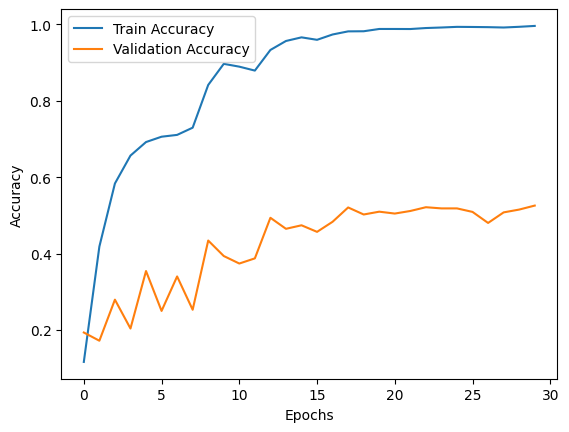

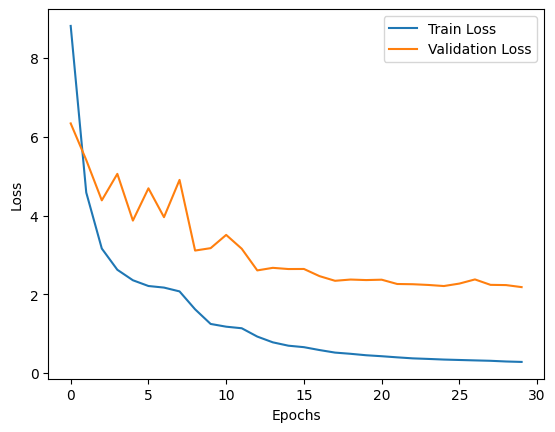

In [ ]:
import matplotlib.pyplot as plt
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Base Model
- Test Loss: 2.0659
- Test Accuracy: 0.4870


Adv Model
- Test Loss: 2.1590
- Test Accuracy: 0.5305
